In [2]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm

In [4]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals
os.environ['TF_DETERMINISTIC_OPS'] = '1'; os.environ['TF_CUDNN_DETERMINISTIC'] = '1'; # allows seeding RNG on GPU

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)
tDIR, sDIR = 'trainXY/', 'testY/'

CPU times: total: 141 ms
Wall time: 139 ms


In [5]:
df = pd.read_csv('XY_diamonds.csv')
df.head()

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
3,0.28,67.9,60.3,4.30,4.26,2.66,P,E,VS2,NaN
4,0.34,67.5,69.4,5.44,5.50,3.32,P,E,VS2,NaN


In [6]:
test_X = df.query('price!=price').drop('price', axis=1)         # slice a test sample
train_sample = df.query('price==price')                         # slice training sample
train_X, train_Y = train_sample.drop('price', axis=1), train_sample.price # split into training I/O

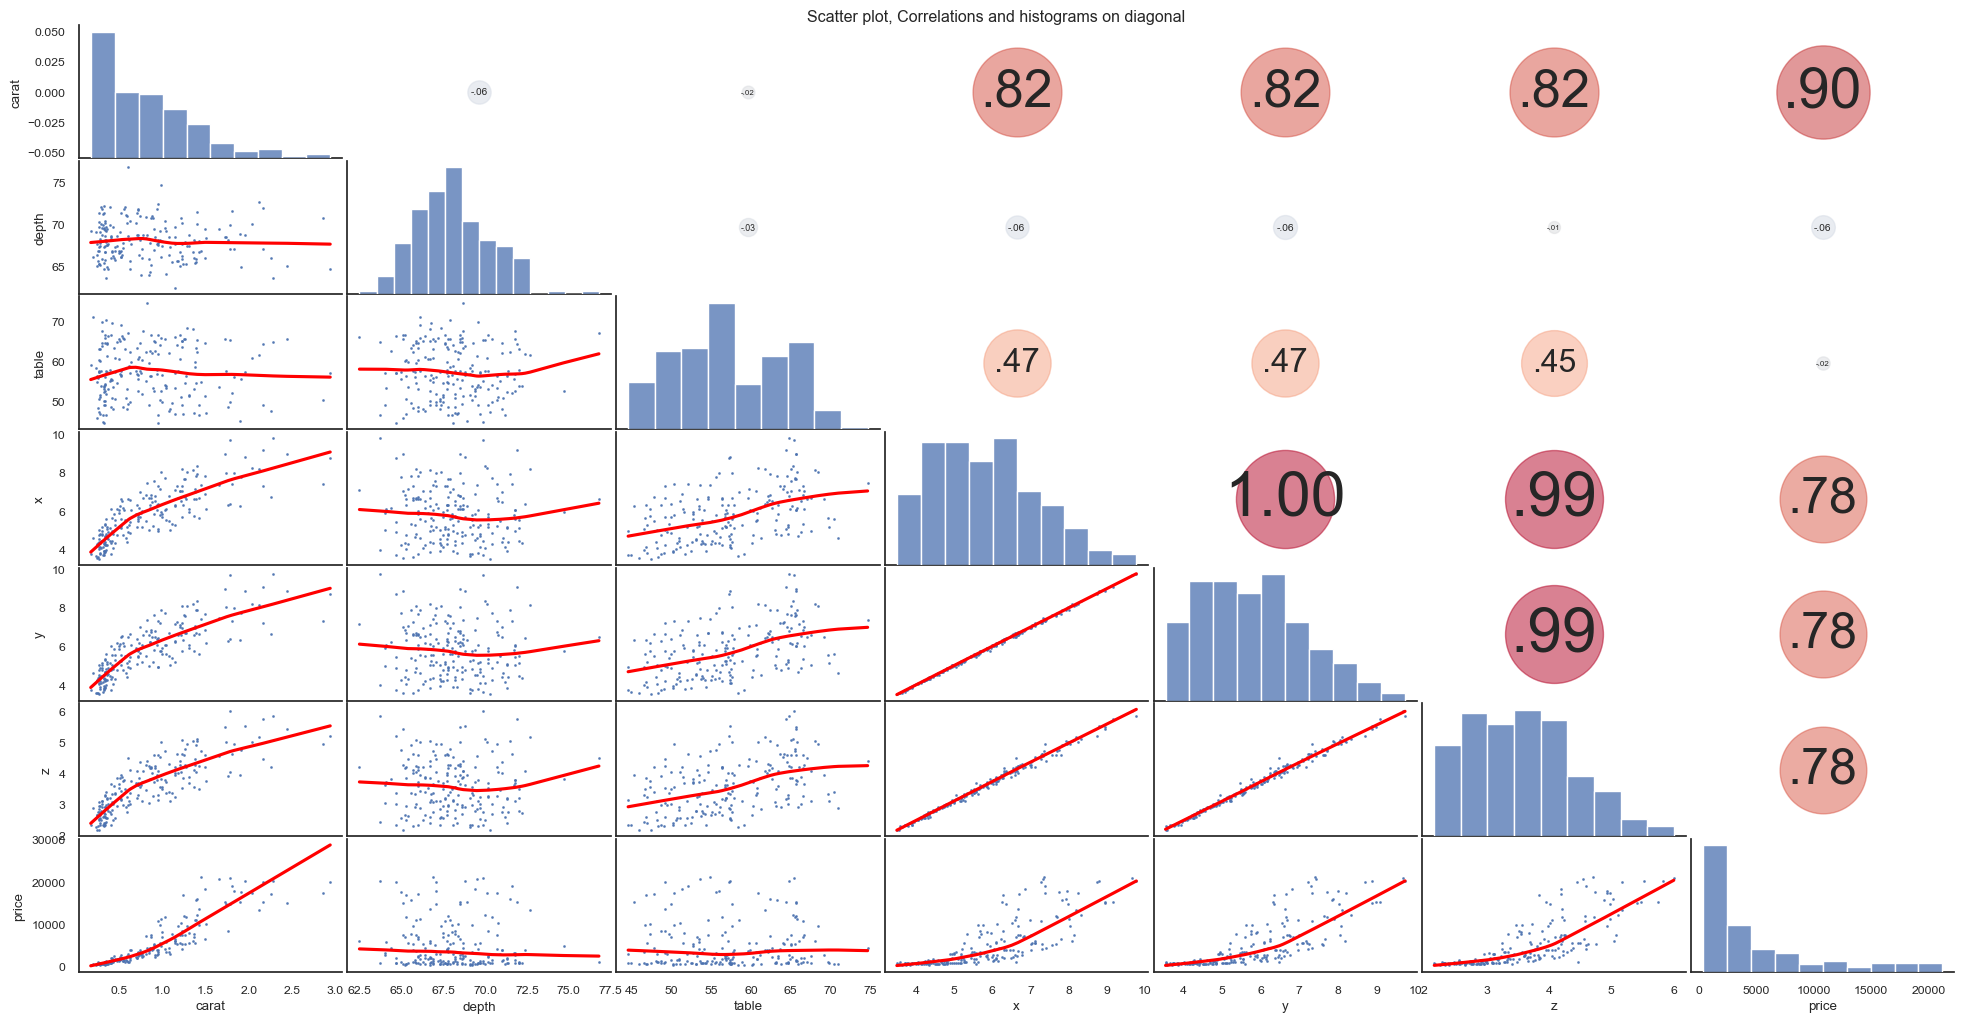

In [7]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(train_sample.head(200))

In [8]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


In [10]:
def clarity_level(clarity):
    return ['I1', 'I2', 'I3',
            'SI1', 'SI2',
            'VS1', 'VS2',
            'VVS1', 'VVS2',
            'IF', 'FL'].index(clarity)
    

In [11]:
train_X.update(train_X['color'].apply(lambda color: ord(color) - ord('D')))
train_X.update(train_X['clarity'].apply(clarity_level))
test_X.update(test_X['color'].apply(lambda color: ord(color) - ord('D')))
test_X.update(test_X['clarity'].apply(clarity_level))

In [12]:
cut_encoded=pd.get_dummies(data=train_X['cut'], dtype=float)
train_X = train_X.join(cut_encoded)

vcut_encoded=pd.get_dummies(data=test_X['cut'], dtype=float)
test_X = test_X.join(vcut_encoded)

In [13]:
train_X = train_X.drop('cut', axis=1)
test_X = test_X.drop('cut', axis=1)

In [14]:
train_X

,carat,depth,table,x,y,z,color,clarity,F,G,I,P,V
40000,0.36,69.5,61.3,4.58,4.52,2.84,4,5,0.0,0.0,0.0,1.0,0.0
40001,0.87,70.7,56.3,6.69,6.74,4.19,3,6,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,3,9,0.0,0.0,1.0,0.0,0.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,4,6,0.0,0.0,1.0,0.0,0.0


In [15]:
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.linear_model import LinearRegression
#train_X0 = train_X.iloc[:20000,:]   # subsample for experimentation
#train_Y0 = train_Y[:20000]   # subsample for experimentation

train_X0 = train_X   # subsample for experimentation
train_Y0 = train_Y   # subsample for experimentation

poly = PolynomialFeatures(degree=2)
train_X0_in = poly.fit_transform(train_X0.select_dtypes(include=np.number))
test_X_in = poly.transform(test_X.select_dtypes(include=np.number))

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_X0_in, train_Y0, test_size=0.2, random_state=42
)
param_grid = {
    "LinearRegression": {"fit_intercept": [True, False]},
    "RidgeRegression": {
        "alpha": [10, 50, 100],
        "max_iter": [15000],
        "solver": [
            "auto",
            "svd",
            "lsqr",
            "sparse_cg",
        ]
    },
    "LassoRegression": {
        "alpha": [0.1, 1, 10],
        "max_iter": [10000],
        "tol": [0.001],
        "warm_start": [True, False],
    },
    "ElasticNet": {
        "alpha": [0.1, 1, 10, 50],
        "l1_ratio": [0.1, 0.5, 0.9],
        "max_iter": [10000],
        "tol": [0.001],
        "warm_start": [True, False],
    },
}

models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(),
    "LassoRegression": Lasso(),
    "ElasticNet": ElasticNet(),
}

for name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5, verbose=3)
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters for {name}:")
    print(grid_search.best_params_)

    # Predict with best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    results = {}
    print(f"Score for {name} with best parameters:")
    for metric in [r2_score, mean_absolute_error]:
        score = metric(y_test, y_pred)
        print(f"{metric.__name__}: {score:.4f}")

        if metric not in results:
            results[metric] = {}
        results[metric][f"{name}_best"] = score


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ................fit_intercept=True;, score=0.857 total time=   0.9s
[CV 2/5] END ................fit_intercept=True;, score=0.857 total time=   1.2s
[CV 3/5] END ................fit_intercept=True;, score=0.803 total time=   0.9s
[CV 4/5] END ................fit_intercept=True;, score=0.858 total time=   0.9s
[CV 5/5] END ................fit_intercept=True;, score=0.856 total time=   0.9s
[CV 1/5] END ...............fit_intercept=False;, score=0.857 total time=   0.9s
[CV 2/5] END ...............fit_intercept=False;, score=0.857 total time=   0.9s
[CV 3/5] END ...............fit_intercept=False;, score=0.803 total time=   0.9s
[CV 4/5] END ...............fit_intercept=False;, score=0.858 total time=   0.9s
[CV 5/5] END ...............fit_intercept=False;, score=0.856 total time=   0.9s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]}, verbose=3)


Best parameters for LinearRegression:
{'fit_intercept': True}
Score for LinearRegression with best parameters:
r2_score: 0.8558
mean_absolute_error: 1077.8105
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END alpha=10, max_iter=15000, solver=auto;, score=0.860 total time=   0.1s
[CV 2/5] END alpha=10, max_iter=15000, solver=auto;, score=0.856 total time=   0.1s
[CV 3/5] END alpha=10, max_iter=15000, solver=auto;, score=0.826 total time=   0.0s
[CV 4/5] END alpha=10, max_iter=15000, solver=auto;, score=0.858 total time=   0.0s
[CV 5/5] END alpha=10, max_iter=15000, solver=auto;, score=0.859 total time=   0.0s
[CV 1/5] END alpha=10, max_iter=15000, solver=svd;, score=0.860 total time=   1.7s
[CV 2/5] END alpha=10, max_iter=15000, solver=svd;, score=0.856 total time=   1.8s
[CV 3/5] END alpha=10, max_iter=15000, solver=svd;, score=0.826 total time=   1.6s
[CV 4/5] END alpha=10, max_iter=15000, solver=svd;, score=0.858 total time=   1.6s
[CV 5/5] END alpha=10, max_

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [10, 50, 100], 'max_iter': [15000],
                         'solver': ['auto', 'svd', 'lsqr', 'sparse_cg']},
             verbose=3)


Best parameters for RidgeRegression:
{'alpha': 100, 'max_iter': 15000, 'solver': 'auto'}
Score for RidgeRegression with best parameters:
r2_score: 0.8546
mean_absolute_error: 1080.7994
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\Mike\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+11, tolerance: 2.313e+09
  model = cd_fast.enet_coordinate_descent(


[CV 1/5] END alpha=0.1, max_iter=10000, tol=0.001, warm_start=True;, score=0.861 total time= 2.5min


KeyboardInterrupt: 

In [21]:
m = LinearRegression()
m.fit(train_X0_in, train_Y0)

LinearRegression()

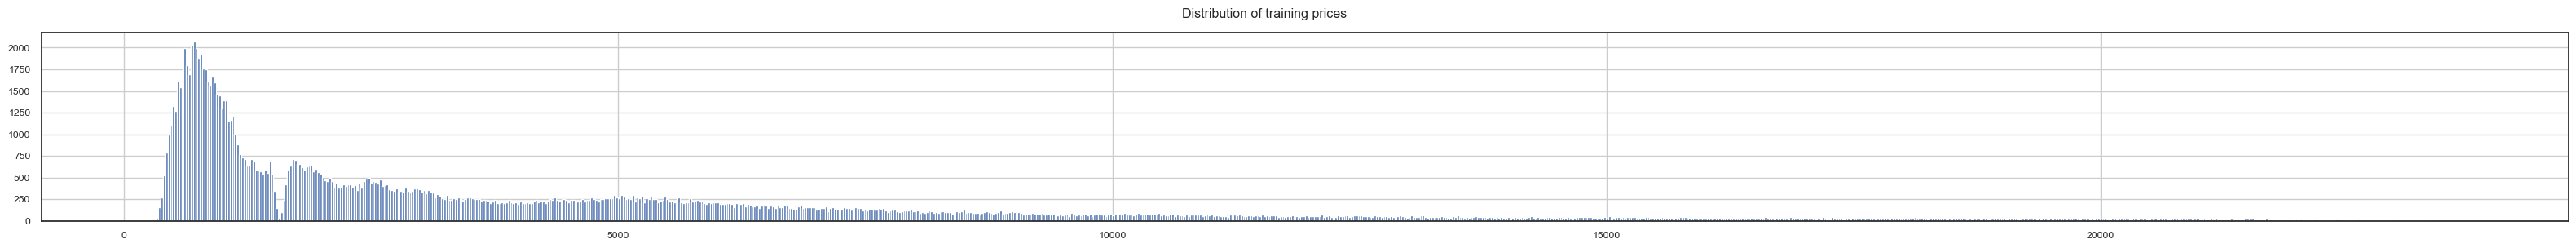

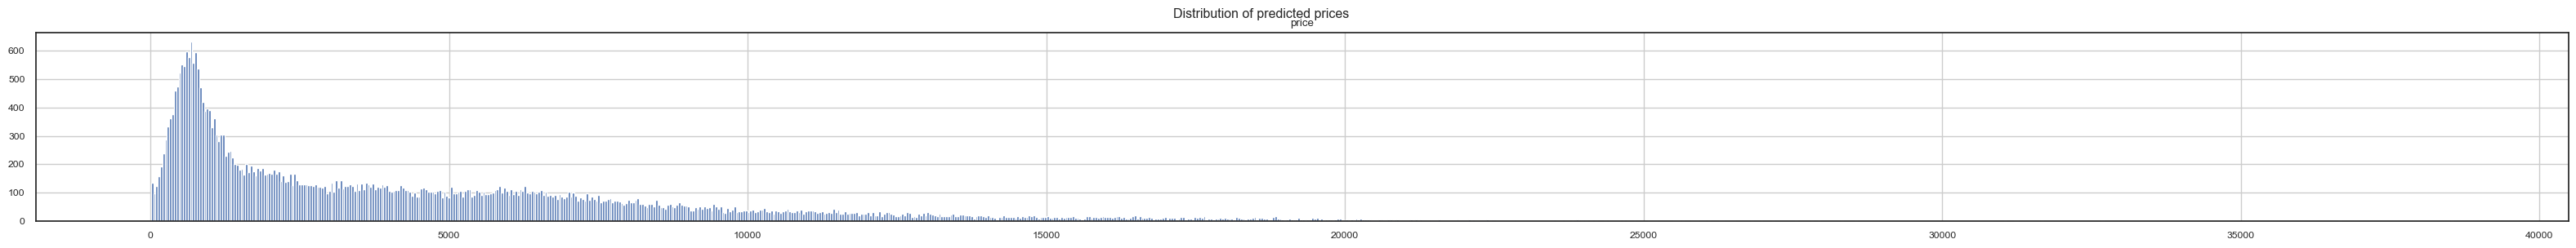

In [22]:
pY = pd.DataFrame(m.predict(test_X_in), index=range(1,len(test_X)+1), columns=['price'])  # ensure that labels and observations are in corresponding order
pY = pY.clip(lower=10)  # ensures no negative prices
_ = train_Y.hist(figsize=(40,3), bins=1000);  
_ = plt.suptitle("Distribution of training prices");
_ = pY.hist(figsize=(40,3), bins=1000);  
_ = plt.suptitle("Distribution of predicted prices");
ToCSV(pY, '💎Baseline🐍')

In [23]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 3 sec
